# ch 17_11. deep neural network 

이전 챕터에서 multilayer perceptron과 이를 학습시킬 수 있는 Back Propagation 알고리즘에 대해서 배웠습니다. 이번 챕터에서는 직접 여러 층으로 구성된 신경망 모델을 만들고, 학습시켜 보겠습니다.

## 데이터 셋 준비

이번 챕터부터는 딥러닝을 처음 시작할 때 많이 사용하는 대표적인 데이터 셋인 MNIST 데이터 셋을 사용해보도록 하겠습니다. 이는 0부터 9까지의 숫자의 손글씨 데이터 셋입니다. 이미지를 보고, 어느 숫자인지 분류하는 딥러닝 모델을 구축해보도록 하겠습니다.

In [40]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

val_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [41]:
len(train_dataset), len(val_dataset)

(60000, 10000)

In [42]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

## Single Layer Perceptron Classifier

층이 하나로 구성된 분류 모델을 만들어보겠습니다. 이전 시간에 배웠던 multiclass classifier와 동일한 모델입니다. 이미지를 일렬로 쫙 펼치기 때문에 첫번째 fully connected layer의 차원은 (28 * 28, hidden_dim)이 됩니다.

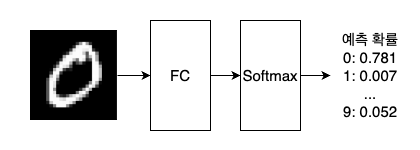

### 모델 작성

In [31]:
import torch

class SingleLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = torch.nn.Linear(input_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [43]:
model = SingleLayerPerceptron(input_dim=28*28, output_dim=10)

In [44]:
from torchsummary import summary

summary(model, input_size=(28, 28, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### 하이퍼 파라미터 셋팅

In [46]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

### 학습

In [47]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [50]:
from tqdm import tqdm

def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        optimizer.zero_grad()
        
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()

        pred = torch.argmax(outputs, dim=1) 
        acc = accuracy_score(y_train, pred)
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [51]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1) 
            acc = accuracy_score(y_val, pred)
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [38]:
from collections import defaultdict
from sklearn.metrics import accuracy_score

def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch: {epoch + 1} train - loss: {train_loss} acc: {train_acc}"\
                  f" val - loss: {val_loss} acc: {val_acc}")
    return logs

In [52]:
logs = train_validate_model(model)

100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 435.99it/s]


epoch: 1 train - loss: 0.5468 acc: 0.8689 val - loss: 0.3327 acc: 0.9124


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 437.44it/s]


epoch: 2 train - loss: 0.3238 acc: 0.9104 val - loss: 0.2947 acc: 0.9186


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 444.25it/s]


epoch: 3 train - loss: 0.2955 acc: 0.9183 val - loss: 0.2787 acc: 0.9222


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 433.90it/s]


epoch: 4 train - loss: 0.2818 acc: 0.921 val - loss: 0.2718 acc: 0.9258


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 420.79it/s]


epoch: 5 train - loss: 0.2735 acc: 0.9233 val - loss: 0.2702 acc: 0.9241


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 429.91it/s]


epoch: 6 train - loss: 0.2682 acc: 0.925 val - loss: 0.2678 acc: 0.9253


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 426.53it/s]


epoch: 7 train - loss: 0.2638 acc: 0.9264 val - loss: 0.268 acc: 0.9251


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 422.94it/s]


epoch: 8 train - loss: 0.2601 acc: 0.9278 val - loss: 0.264 acc: 0.9271


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 421.85it/s]


epoch: 9 train - loss: 0.2571 acc: 0.9292 val - loss: 0.2652 acc: 0.9266


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 423.04it/s]

epoch: 10 train - loss: 0.2548 acc: 0.9298 val - loss: 0.2632 acc: 0.9272


### 결과 시각화

In [62]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

## Multilayer Perceptron Classifier
입력으로 들어오는 이미지를 일렬로 쭉 펼친 다음, 신경망을 2번 통과시키는 모델을 작성합니다. 활성화 함수로는 sigmoid를 사용합니다. 구조를 시각화 해보면 아래와 같습니다.

이미지를 일렬로 쫙 펼치기 때문에 첫번째 fully connected layer의 차원은 (28 * 28, hidden_dim)이 됩니다.

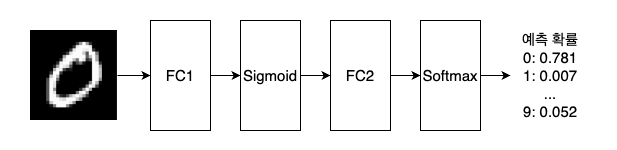


### 모델 작성

In [57]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
model = MultiLayerPerceptron(input_dim=28*28, hidden_dim=50, output_dim=10)

In [59]:
summary(model, input_size=(28, 28, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          39,250
           Sigmoid-2                   [-1, 50]               0
            Linear-3                   [-1, 50]           2,550
           Sigmoid-4                   [-1, 50]               0
            Linear-5                   [-1, 10]             510
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


### 하이퍼 파라미터 셋팅

In [60]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

### 학습

In [61]:
logs = train_validate_model(model)

100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 416.12it/s]


epoch: 1 train - loss: 0.9069 acc: 0.7725 val - loss: 0.3513 acc: 0.9067


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 416.34it/s]


epoch: 2 train - loss: 0.2895 acc: 0.9195 val - loss: 0.2394 acc: 0.9331


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 413.42it/s]


epoch: 3 train - loss: 0.2129 acc: 0.9392 val - loss: 0.1982 acc: 0.9425


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 406.90it/s]


epoch: 4 train - loss: 0.1708 acc: 0.9514 val - loss: 0.1639 acc: 0.9516


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 415.31it/s]


epoch: 5 train - loss: 0.143 acc: 0.9588 val - loss: 0.1436 acc: 0.9583


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 408.30it/s]


epoch: 6 train - loss: 0.123 acc: 0.964 val - loss: 0.1306 acc: 0.9614


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 409.70it/s]


epoch: 7 train - loss: 0.1079 acc: 0.9687 val - loss: 0.1195 acc: 0.9629


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 403.61it/s]


epoch: 8 train - loss: 0.0958 acc: 0.9723 val - loss: 0.1142 acc: 0.9666


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 411.11it/s]


epoch: 9 train - loss: 0.0861 acc: 0.9749 val - loss: 0.1075 acc: 0.9663


100%|████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 404.89it/s]

epoch: 10 train - loss: 0.0773 acc: 0.9775 val - loss: 0.106 acc: 0.9672


### 결과 시각화

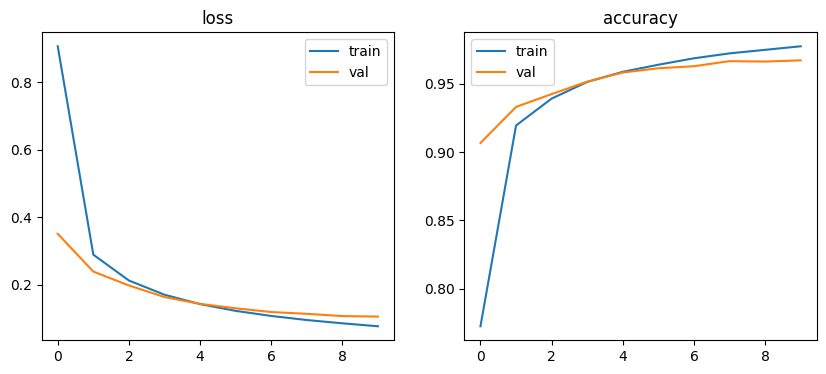

In [63]:
plot_logs(logs)

층을 하나 더 쌓았을 뿐인데 모델의 정확도가 96.8%까지 개선되는 것을 확인할 수 있습니다.

## 정리

이번 챕터에서는 여러개의 층으로 구성된 신경망 모델을 만들고, MNIST 데이터 셋에 대해서 학습을 시켜보았습니다. 그 결과 96%라는 준수한 성능을 보여주었습니다. 실습 과정에서 사용한 코드 구성은 모델이 더 복잡해지더라도 대부분 적용할 수 있는 코드들이므로 사용법을 잘 숙지하시기 바랍니다.